In [1]:
using Plots
using LinearAlgebra
using Revise
using NeuralVerification
using NeuralVerification:Network, Layer, ReLU, Id, read_nnet, compute_output
using LazySets

┌ Info: Precompiling NeuralVerification [146f25fa-00e7-11e9-3ae5-fdbac6e12fa7]
└ @ Base loading.jl:1278
┌ Warning: Package NeuralVerification does not have CPLEX in its dependencies:
│ - If you have NeuralVerification checked out for development and have
│   added CPLEX as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with NeuralVerification
└ Loading CPLEX into NeuralVerification from project dependency, future warnings for NeuralVerification are suppressed.


In [2]:
include("unicycle_env.jl")
include("controller.jl")
include("safe_set.jl")
include("problem.jl")
net_path = "../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"

"../nnet/unicycle-FC3-100-rk4/epoch_1000.nnet"

In [3]:
function get_rp(net_path)
    obj_cost = [1,1,10,10]
#     obj_cost = [1000,1000,1,1]
#     obj_cost = [1000,1000,1,1000]
    x0 = [1,0,1,π/2]
    xg = [1,4,0,π/2]
    net = read_nnet(net_path)
    curve_rp = RP(net, obj_cost, x0, xg);
    return curve_rp
end
rp = get_rp(net_path);

In [4]:
function get_Xref(x0, xg, T, dt)
    tf = T*dt
    dp = [xg[1]-x0[1], xg[2]-x0[2]]
    da = xg[4]-x0[4]
    a = atan(dp[2], dp[1])
    v = norm(dp)/tf
    v = max(min(v, 1),-1)
    vx = v * cos(a)
    vy = v * sin(a)
    Xref = [[x0[1]+vx*k*dt, x0[2]+vy*k*dt, v, a] for k = 1:T]
    Xref[end][3] = 0
    return Xref
end

get_Xref (generic function with 1 method)

In [5]:
function tracking(rp::RP, ctrl; fps=10, tf=2, obstacle=nothing, verbose=false)
    T=Int(ceil(fps*tf))
    dt=1.0/fps
    x = rp.x0
    X = [copy(rp.x0) for k = 1:T]
    U = [zeros(2) for k = 1:T-1]
    safe_sets = []
    Xrefs = []
    tot_time = 0
    for i in 1:T-1
        Xref = get_Xref(x, rp.xg, fps, dt)
        xref = Xref[1]
        push!(Xrefs, Xref)
#         @show xref
        timed_result = @timed get_control(ctrl, xref, x, rp.net, rp.obj_cost, dt, obstacle=obstacle)
        u, safe_set = timed_result.value
        if isnothing(u)
            return X[1:i], U[1:i-1], safe_sets, Xrefs
        end
        push!(safe_sets, safe_set)
        tot_time += timed_result.time
        if verbose
            @show x
            @show xref
            @show u
            p = phi(x, obstacle)
            @show p
#         grad_p = grad_phi(x, obstacle)
#         dot_x = compute_output(rp.net, [x;u])
#         dot_p = grad_p'dot_x
#         @show rp.xg-x

#         @show grad_p
#         @show dot_x
#         @show dot_p
        end
        x = forward(rp.net, x, u, dt)
        X[i+1] = x
        U[i] = u
    end
#     @show length(Xrefs)
    push!(Xrefs, Xrefs[end])
#     @show length(Xrefs)
    return X, U, safe_sets, Xrefs
end

tracking (generic function with 1 method)

In [14]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.6,2.4],1.0)
shoot_ctrl = ShootingController(1000)
fps = 60
tf = 6
tot_cnt = 100
fail_cnt = 0
for i = 1:tot_cnt
    Xshoot, Ushoot, safe_sets, Xrefs = tracking(rp, shoot_ctrl, fps=fps, tf=tf, obstacle=obstacle, verbose=false);
    if length(Xshoot) < fps*tf
        @show i,length(Xshoot)
        fail_cnt += 1
    end
end
@show fail_cnt

(i, length(Xshoot)) = (9, 85)
(i, length(Xshoot)) = (11, 85)
(i, length(Xshoot)) = (21, 85)
(i, length(Xshoot)) = (23, 85)
(i, length(Xshoot)) = (32, 85)
(i, length(Xshoot)) = (34, 85)
(i, length(Xshoot)) = (35, 85)
(i, length(Xshoot)) = (43, 85)
(i, length(Xshoot)) = (46, 85)
(i, length(Xshoot)) = (51, 85)
(i, length(Xshoot)) = (62, 85)
(i, length(Xshoot)) = (68, 85)
(i, length(Xshoot)) = (73, 85)
(i, length(Xshoot)) = (74, 85)
(i, length(Xshoot)) = (78, 85)
(i, length(Xshoot)) = (83, 85)
(i, length(Xshoot)) = (90, 85)
fail_cnt = 17


17

In [16]:
@show 1-fail_cnt/100

1 - fail_cnt / 100 = 0.83


0.83

In [48]:
obstacle = Ball2([1.6,2.4],1.0)
shoot_ctrl = ShootingController(100000)
fps = 60
tf = 6
Xshoot, Ushoot, safe_sets, Xrefs = tracking(rp, shoot_ctrl, fps=fps, tf=tf, obstacle=obstacle, verbose=false);

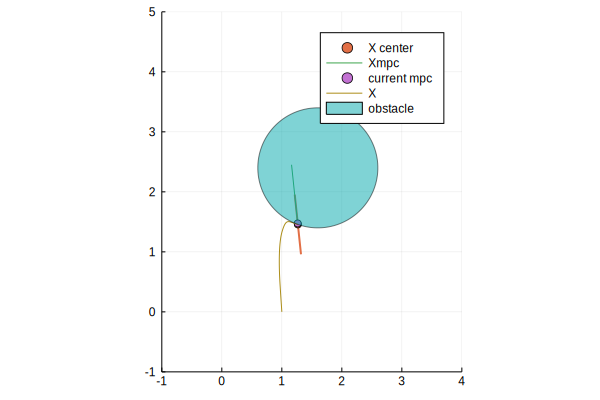

true

In [50]:
visualize(Xshoot, Xmpcs=Xrefs, obstacle=obstacle, fps=fps, save_frame=(200, "../results/obs_stuck.png"))

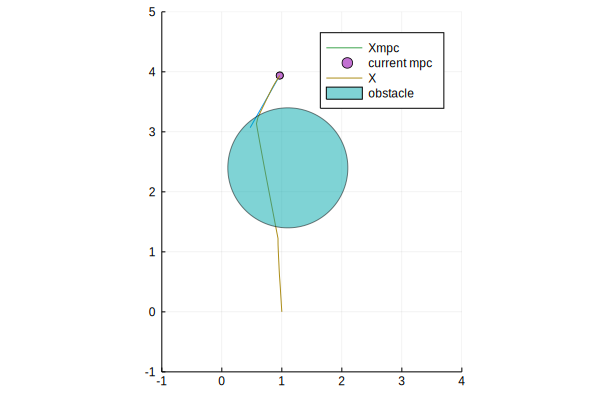

In [40]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.1,2.4],1.0)
shoot_ctrl = ShootingController(1000)
fps = 60
Xshoot, Ushoot, safe_sets, Xrefs = tracking(rp, shoot_ctrl, T=5*fps, dt=1/fps, obstacle=obstacle, verbose=false);
visualize(Xshoot, Xmpcs=Xrefs, obstacle=obstacle, fps=fps)

In [39]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.6,2.4],1.0)
dx_bound = [10, 10, 10, 10]
nv_ctrl = NvController(dx_bound, warm_start=true)
# Xnv, Unv = tracking(curve_tp, nv_ctrl, obstacle=obstacle);
fps = 60
tf = 6
Xnv, Unv, safe_sets, Xrefs = tracking(rp, nv_ctrl, fps=fps, tf=tf, obstacle=obstacle, verbose=false);

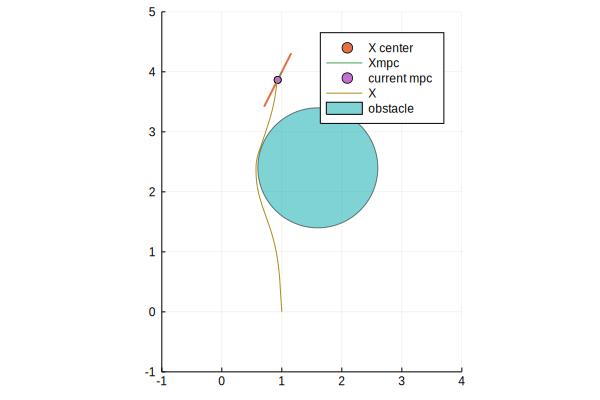

true

In [42]:
# visualize(Xnv, Xmpcs=Xrefs, obstacle=obstacle, fps=fps)
# visualize(Xnv, Xmpcs=Xrefs, obstacle=obstacle, fps=fps, save_name="../results/obs_after_nv.gif")
visualize(Xnv, Xmpcs=Xrefs, obstacle=obstacle, fps=fps, save_frame = (300, "../results/obs_after.png"))

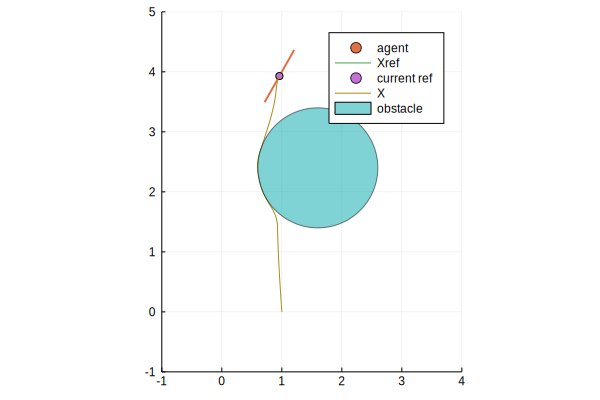

true

In [61]:
visualize(Xnv, Xmpcs=Xrefs, obstacle=obstacle, fps=fps)

In [86]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.6,2.4],1.0)
shoot_ctrl = ShootingController(1000)
fps = 60
tf = 6
Xshoot, Ushoot, safe_sets, Xrefs = tracking(rp, shoot_ctrl, fps=fps, tf=tf, obstacle=obstacle, verbose=false);

xref = [1.0, 0.016666666666666666, 1.0, 1.5707963267948966]
xref = [0.9988835128879826, 0.033647266988108125, 1.0, 1.570514837185252]
xref = [0.9977517984613532, 0.05062043431245024, 1.0, 1.5702270724959846]
xref = [0.9966325860141007, 0.06755144867392826, 1.0, 1.5699400121810196]
xref = [0.9955117497209854, 0.08451975715768326, 1.0, 1.5696500438270746]
xref = [0.9943634506637551, 0.101475422252638, 1.0, 1.5693505117701805]
xref = [0.9932530251528844, 0.11847686024005566, 1.0, 1.569058099864642]
xref = [0.9921352418559217, 0.13545417357211206, 1.0, 1.568761224187853]
xref = [0.9910468995016758, 0.15243373295444881, 1.0, 1.5684693793903521]
xref = [0.9899088069573716, 0.16938770128098268, 1.0, 1.568161977789546]
xref = [0.9888001744471998, 0.1863838683331562, 1.0, 1.5678595358417509]
xref = [0.9877091548832752, 0.20336577154567337, 1.0, 1.5675590378065614]
xref = [0.9865843324500694, 0.22033450687975914, 1.0, 1.5672469091980725]
xref = [0.9854599113829091, 0.2373535153231602, 1.0, 1.566

In [87]:
length(Xrefs)

99

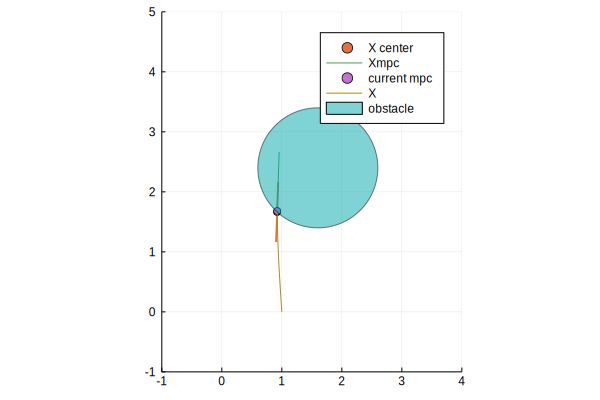

true

In [88]:
visualize(Xshoot, Xmpcs=Xrefs, obstacle=obstacle, fps=5*fps)

In [60]:

function visualize(X; Xref=nothing, Xmpcs=nothing, xlims = (-1,4), ylims = (-1,5), obstacle=nothing, safe_sets=nothing, save_name=nothing, fps=10)
    step = length(X)
    if !isnothing(Xref)
        xrefs = [Xref[i][1] for i in 1:length(Xref)]
        yrefs = [Xref[i][2] for i in 1:length(Xref)]
    end
    xs = [X[i][1] for i in 1:length(X)]
    ys = [X[i][2] for i in 1:length(X)]
    
    dpi = isnothing(save_name) ? 100 : 300
    anim = @animate for i = 1:step
        IJulia.clear_output(true)
        x = X[i]
        sx, sy, c = get_unicycle_endpoints(x)
        p = plot(sx, sy, linewidth=2, xlims = xlims, ylims = ylims, color=2, label="", aspect_ratio=:equal, dpi=dpi)
        scatter!(p, c[1:1], c[2:2], label="agent", color=2)
        if !isnothing(Xref)
            plot!(xrefs, yrefs, label="Xref")
            scatter!([xrefs[i]], [yrefs[i]], label="current ref")
        end
        if !isnothing(Xmpcs)
            plot!([Xmpcs[i][j][1] for j in 1:length(Xmpcs[i])], [Xmpcs[i][j][2] for j in 1:length(Xmpcs[i])], label="Xref")
            scatter!([Xmpcs[i][1][1]], [Xmpcs[i][1][2]], label="current ref")
        end
        plot!(xs, ys, label="X")
        if !isnothing(obstacle)
            plot!(obstacle, label="obstacle")
        end
        if !isnothing(safe_sets)
            plot!(safe_sets[i], label="obstacle")
        end
        if isnothing(save_name)
            Plots.display(p)
            sleep(1.0/fps)
        end
    end
    isnothing(save_name) || return gif(anim, save_name, fps = fps)
end

visualize (generic function with 1 method)

In [ ]:
visualize(Xnv, Xmpcs=Xrefs, save_name="straight_nv.gif")

In [85]:
function phi(x, obs)
    o = obs.center
    d = (x[1]-o[1])^2 + (x[2]-o[2])^2
    vx = x[3] * cos(x[4])
    vy = x[3] * sin(x[4])
    dot_d = 2*(x[1]-o[1])*vx + 2*(x[2]-o[2])*vy
#     return obs.radius - d^2 - 0.5*dot_d
    return obs.radius - d^2 - 0.0*dot_d
end

function grad_phi(x, obs)
    o = obs.center
    d = (x[1]-o[1])^2 + (x[2]-o[2])^2
    vx = x[3] * cos(x[4])
    vy = x[3] * sin(x[4])
    dot_d = 2*(x[1]-o[1])*vx + 2*(x[2]-o[2])*vy
    grad_d = [2*(x[1]-o[1]), 2*(x[2]-o[2]), 0, 0]
    grad_dot_d = [2*vx, 2*vy, 2*(x[1]-o[1])*cos(x[4]) + 2*(x[2]-o[2])*sin(x[4]), 2*(x[1]-o[1])*x[3]*(-sin(x[4])) + 2*(x[2]-o[2])*x[3]*(cos(x[4]))]
#     return -2*d*grad_d - 0.5*grad_dot_d
    return -2*d*grad_d - 0.0*grad_dot_d
end

grad_phi (generic function with 1 method)

In [ ]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.6,2.4],1.0)
shoot_ctrl = ShootingController(1000)
fps = 60
Xshoot, Ushoot, safe_sets, Xrefs = tracking(rp, shoot_ctrl, T=5*fps, dt=1/fps, obstacle=obstacle, verbose=false);
visualize(Xshoot, Xmpcs=Xrefs, obstacle=obstacle, fps=fps)

In [89]:
# visualize(Xshoot, Xmpcs=Xrefs)
obstacle = Ball2([1.6,2.4],1.0)
dx_bound = [10, 10, 10, 10]
nv_ctrl = NvController(dx_bound, warm_start=true)
# Xnv, Unv = tracking(curve_tp, nv_ctrl, obstacle=obstacle);
fps = 60
tf = 6
Xnvf, Unv, safe_sets, Xrefsf = tracking(rp, nv_ctrl, fps=fps, tf=tf, obstacle=obstacle, verbose=false);

xref = [1.0, 0.016666666666666666, 1.0, 1.5707963267948966]
xref = [0.9988804499728259, 0.03364755887019706, 1.0, 1.5705140649399407]
xref = [0.9977560767000131, 0.050626502840745775, 1.0, 1.57022815489114]
xref = [0.9966321582646253, 0.06760664360056819, 1.0, 1.5699398913860438]
xref = [0.9955087445072299, 0.08458800392283441, 1.0, 1.5696492563135658]
xref = [0.9943858608153096, 0.10157059192616226, 1.0, 1.5693562249702948]
xref = [0.9932635327240855, 0.11855441575670092, 1.0, 1.5690607722531789]
xref = [0.992141786043056, 0.13553948363054433, 1.0, 1.568762872683363]
xref = [0.9910206468571525, 0.15252580386207548, 1.0, 1.568462500398061]
xref = [0.9899001415314737, 0.16951338484380518, 1.0, 1.5681596291431603]
xref = [0.9887817097109868, 0.18650240008285712, 1.0, 1.5678546026597668]
xref = [0.987666877444834, 0.20349293687724848, 1.0, 1.56754779361258]
xref = [0.9865555789371245, 0.2204849849538863, 1.0, 1.5672391602528204]
xref = [0.9854478338760393, 0.2374785502899978, 1.0, 1.56692

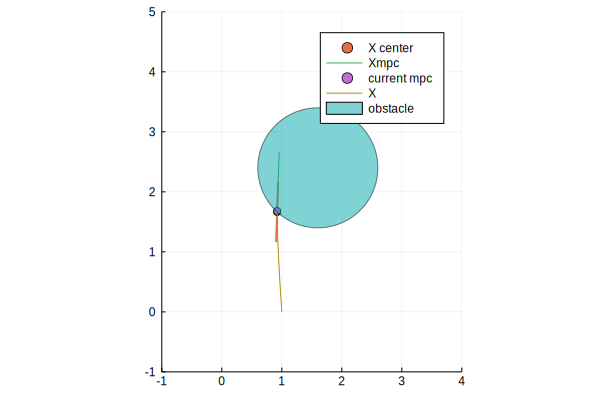

true

In [93]:
visualize(Xnvf, Xmpcs=Xrefsf, obstacle=obstacle, fps=fps)

┌ Info: Saved animation to 
│   fn = /home/wth/dev/nn-safe-control/results/obs_before_nv.gif
└ @ Plots /home/wth/.julia/packages/Plots/cc8wh/src/animation.jl:98


Plots.AnimatedGif("/home/wth/dev/nn-safe-control/results/obs_before_nv.gif")
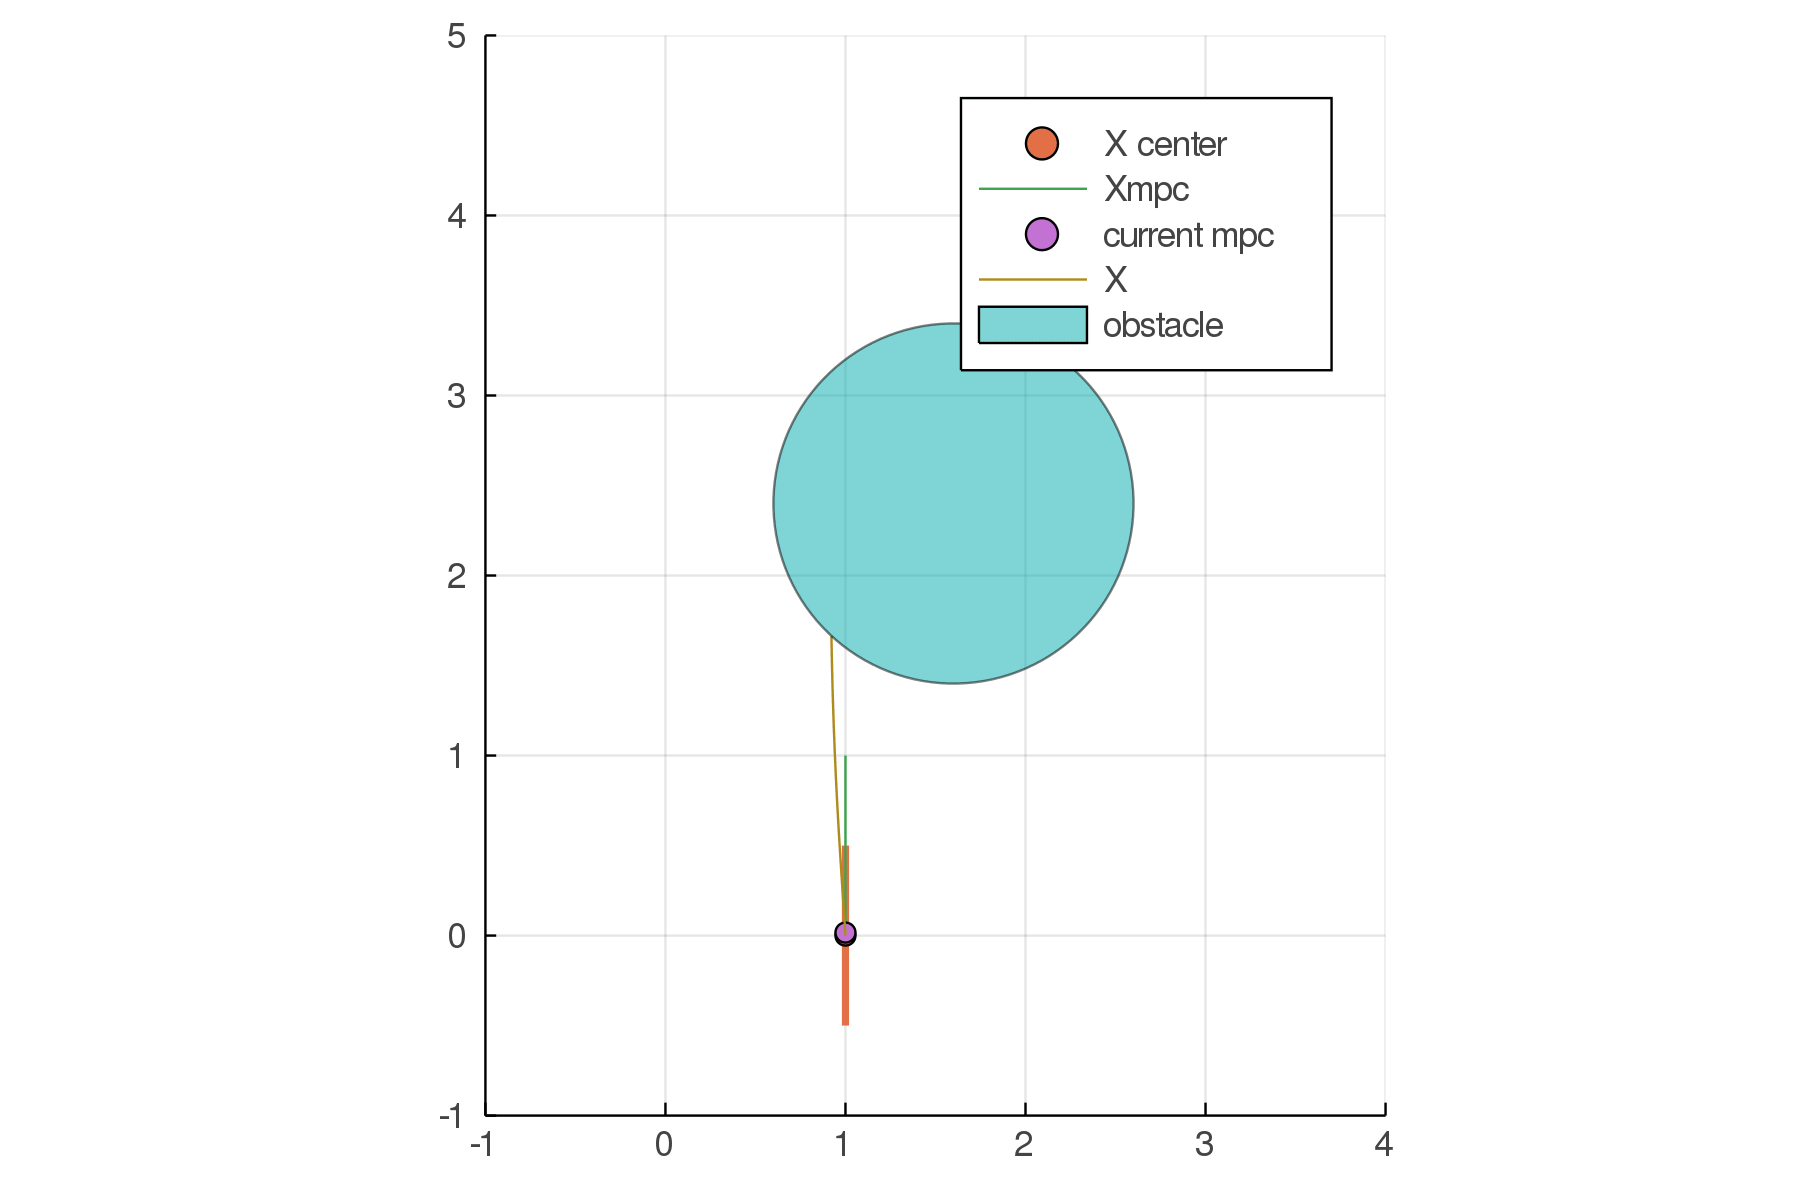

In [94]:
visualize(Xnvf, Xmpcs=Xrefsf, obstacle=obstacle, fps=fps, save_name="../results/obs_before_nv.gif")